In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random
from scipy import sparse
from scipy.sparse.linalg import spsolve
from functools import wraps
import time

2024-12-20 10:01:26.303716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734710486.320996    5682 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734710486.326122    5682 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 10:01:26.345264: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(42)

In [8]:
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print('func:%r took: %2.4f sec' % \
          (f.__name__, te-ts))
        return result
    return wrap

In [9]:
@timing
def pre_process_sample(spectrum):
    global smoothed
    def modified_z_score(ys):
        ysb = np.diff(ys) # Differentiated intensity values
        median_y = np.median(ysb) # Median of the intensity values
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
        modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
        return modified_z_scores
        
    # The next function calculates the average values around the point to be replaced.
    def fixer(y,ma):
        threshold = 7 # binarization threshold
        spikes = abs(np.array(modified_z_score(y))) > threshold
        y_out = y.copy()
        for i in np.arange(len(spikes)):
            if spikes[i] != 0:
                w = np.arange(i-ma,i+1+ma)
                we = w[spikes[w] == 0]
                y_out[i] = np.mean(y[we])
        return y_out

    def baseline_als(y, lam, p, niter=100):
        L = len(y)
        D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
        w = np.ones(L)
        for i in range(niter):
            W = sparse.spdiags(w, 0, L, L)
            Z = W + lam * D.dot(D.transpose())
            z = spsolve(Z, w*y)
            w = p * (y > z) + (1-p) * (y < z)
        return z

    spectrum = fixer(spectrum, ma=10)
    w, p = 9, 2

    #spectrum = #savgol_filter(spectrum, w, polyorder = p, deriv=0)

    l = 10000000
    p = 0.05

    estimated_baselined = baseline_als(spectrum, l, p)

    spectrum -= estimated_baselined

    return np.array(spectrum)

In [20]:
data = json.loads(open('data.json', 'r').read())

In [21]:
X = np.array(data['spectrums'])
y = np.array(data['concentrations'])

X.shape

(1000, 1000)

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [39]:
denoise_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(2, activation='relu'),
    Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(X_train.shape[1],)
])

denoise_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

denoise_history = denoise_model.fit(X_train, X_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.1085e-04 - val_loss: 6.5067e-04
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2859e-04 - val_loss: 5.1827e-04
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0403e-04 - val_loss: 4.8568e-04
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8176e-04 - val_loss: 4.7396e-04
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7114e-04 - val_loss: 4.6255e-04
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6181e-04 - val_loss: 4.5187e-04
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5116e-04 - val_loss: 4.4619e-04
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4220e-04 - val_loss: 4.4212e-04
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4080e-04 - val_loss: 4.4044e-04
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4281e-04 - val_loss: 4.3956e-04
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3854e-

In [42]:
X_train = denoise_model.predict(X_train)
X_test = denoise_model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [30]:
# Initialize the TensorFlow model
regressor_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1])  # Output layer for 20 components
])

# Compile the model
regressor_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model and save the training history
regressor_history = regressor_model.fit(X_train, y_train, epochs=400, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/400


/home/aniruth/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0142 - val_loss: 0.0061
Epoch 2/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 3/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 4/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 5/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 6/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 7/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 8/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 9/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 10/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 11/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 12/400
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_lo

In [32]:
# Predict on the test set
y_pred = regressor_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

mad = np.mean(np.abs(y_pred - y_test))

f"Mean Squared Error: {mse} | Mean Absolute Deviation: {mad}"

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


'Mean Squared Error: 0.0021654285400764953 | Mean Absolute Deviation: 0.03800735925945506'

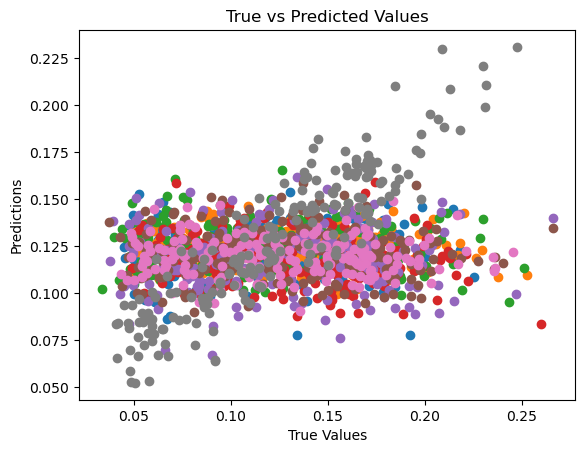

In [33]:
# Plot the results
plt.figure()
plt.plot(y_test, y_pred, 'o')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

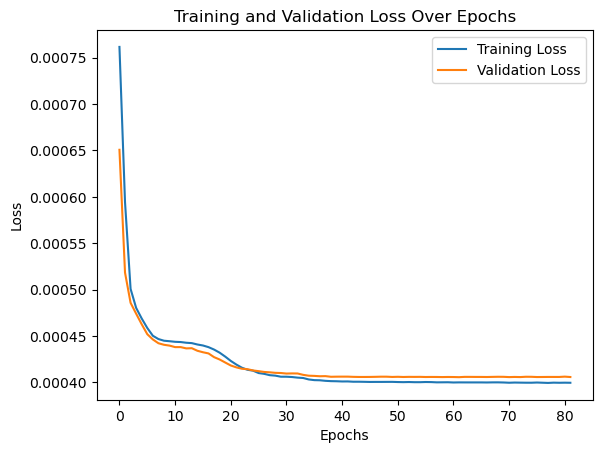

In [43]:
# Plot the training history
plt.figure()
plt.plot(denoise_history.history['loss'], label='Training Loss')
plt.plot(denoise_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

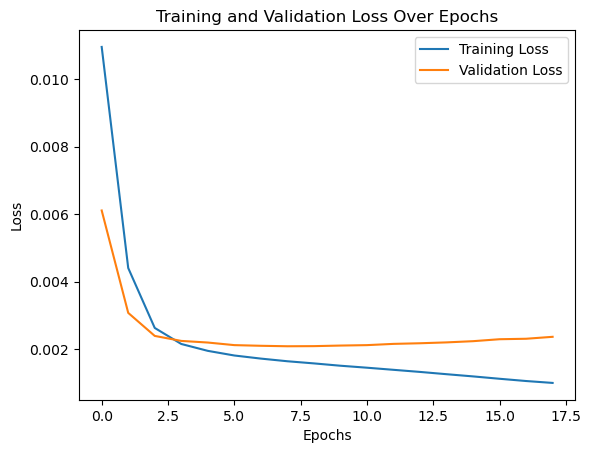

In [36]:
# Plot the training history
plt.figure()
plt.plot(regressor_history.history['loss'], label='Training Loss')
plt.plot(regressor_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [37]:
model.save('models/v5.keras')